In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb

## Question 1

In [2]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


plt.ion()

pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("Chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
print('Chisq Mean of ', len(resid)-len(pars), 'with Standard Deviation of', np.sqrt(2*(len(resid)-len(pars))))
#plt.clf()
#plt.plot(ell,model)
#plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
#plt.show()
    

Chisq is  3272.2033778089576  for  2501  degrees of freedom.
Chisq Mean of  2501 with Standard Deviation of 70.7248188403477


Taking the mean to be $n$, the number of degrees of freedom and the standard deviation the square root of variance, $\sqrt{2n}$, from the printed values above, we can see that our Chisq value for our parameters is much greater than 5$\sigma$ from the mean; therefore, not a good fit.

## Question 2

In [8]:
def Deriv(pars, delta):
    H0, ombh2, omch2, tau, As, ns = pars
    d_H0, d_ombh2, d_omch2, d_tau, d_As, d_ns = delta
    model = get_spectrum(pars)[:len(spec)]
    jacob = np.zeros((len(model), len(pars)))
    jacob[:, 0] = (get_spectrum([H0+d_H0, ombh2, omch2, tau, As, ns])[:len(model)] - model)/d_H0
    jacob[:, 1] = (get_spectrum([H0, ombh2+d_ombh2, omch2, tau, As, ns])[:len(model)] - model)/d_ombh2
    jacob[:, 2] = (get_spectrum([H0, ombh2, omch2+d_omch2, tau, As, ns])[:len(model)] - model)/d_omch2
    jacob[:, 3] = (get_spectrum([H0, ombh2, omch2, tau+d_tau, As, ns])[:len(model)] - model)/d_tau
    jacob[:, 4] = (get_spectrum([H0, ombh2, omch2, tau, As+d_As, ns])[:len(model)] - model)/d_As
    jacob[:, 5] = (get_spectrum([H0, ombh2, omch2, tau, As, ns+d_ns])[:len(model)] - model)/d_ns
    
    return jacob, model

def update_lmb(lamda,success):
    if success:
        lamda=lamda/1.5
        if lamda<0.5:
            lamda=0
    else:
        if lamda==0:
            lamda=1
        else:
            lamda=lamda*1.5**2
    return lamda

In [26]:
pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
threshold = 0.01
deltas = 0.05*pars
derivs, model = Deriv(pars, deltas)
resid = spec-model
chisq = np.sum((resid/errs)**2)
lmb = 0
for i in range(10):
    LHS = ((derivs.T / errs**2) @ (derivs) + lmb*np.diag(np.diag((derivs.T / errs**2) @ derivs)))
    RHS = (derivs.T / errs**2) @ (resid) 
    dm = np.linalg.inv(LHS) @ RHS
    new_pars = pars + dm
    new_derivs, new_model = Deriv(new_pars, deltas)
    new_resid = spec-new_model
    new_chisq = np.sum((new_resid/errs)**2)
    delta_chisq = new_chisq - chisq
    if new_chisq < chisq:
        pars, resid, derivs, chisq = new_pars, new_resid, new_derivs, new_chisq
        lmb = update_lmb(lmb, success = True)
        if lmb == 0:
            if (abs(delta_chisq) < threshold):
                print(pars)
                break
    else:
        lmb = update_lmb(lmb, success = False)

[6.91705312e+01 2.25387351e-02 1.15855041e-01 9.77888013e-02
 2.26553745e-09 9.77073988e-01]


In [229]:
cov = np.linalg.inv(LHS)
par_err = np.sqrt(abs(np.diag(cov)))
output_pars = np.asarray((pars, par_err)).T
#np.savetxt('planck_fit_params.txt', output_pars)

LM Method was written and run using initial parameters from Q1. Output parameters of the LM are saved into planck_fits_params.fits as requested and we observe that the LM method converges after 5 steps.

## Question 3

We draw trial steps using the matrix generated from our LM run in Q2 using cholesky method. We run the MCMC over 5000 steps with the same initial parameters previously used with a scale factor of 0.85 to get approximately 25\% acceptance rate.

In [230]:
def steps(cov):
    cholesky = np.linalg.cholesky(cov)
    step = cholesky@np.random.randn(len(cholesky))
    return step

def mcmc(data, start, cov, nstep, scale):
    accepted_steps = 0
    npars = len(start)
    pars = np.zeros((nstep, npars+1))
    pars[0,0:-1] = start
    resid = data-get_spectrum(start)[:len(data)]
    chisq = np.sum((resid/errs)**2) 
    pars[0, -1] = chisq
    pos = start
    for i in range(nstep-1):
        if i%100 == 0:
            print('Step', i)
        new_pos = pos + scale*steps(cov)
        new_resid = data-get_spectrum(new_pos)[:len(data)]
        new_chisq = np.sum((new_resid/errs)**2)
        if new_chisq < chisq:
            accept = True
            accepted_steps += 1
        else:
            delta_chisq = new_chisq - chisq
            prob = np.exp(-0.5*delta_chisq)
            if np.random.rand()<prob:
                accept = True
                accepted_steps += 1
            else:
                accept = False
        if accept:
            pos = new_pos
            chisq = new_chisq
        pars[i+1, 0:-1] = pos
        pars[i+1, -1] = chisq
    return pars, accepted_steps

In [159]:
pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
mcmc_out, n_accept = mcmc(spec, pars, cov, 5000, 0.85)

Step 0
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Step 1100
Step 1200
Step 1300
Step 1400
Step 1500
Step 1600
Step 1700
Step 1800
Step 1900
Step 2000
Step 2100
Step 2200
Step 2300
Step 2400
Step 2500
Step 2600
Step 2700
Step 2800
Step 2900
Step 3000
Step 3100
Step 3200
Step 3300
Step 3400
Step 3500
Step 3600
Step 3700
Step 3800
Step 3900
Step 4000
Step 4100
Step 4200
Step 4300
Step 4400
Step 4500
Step 4600
Step 4700
Step 4800
Step 4900


In [160]:
#np.savetxt('mcmc_out5000.txt', mcmc_out)
print(n_accept)

1324


In [161]:
planck_chain = np.zeros(mcmc_out.shape)
planck_chain[:, [1,2,3,4,5,6,0]] = mcmc_out[:,[0,1,2,3,4,5,6]]

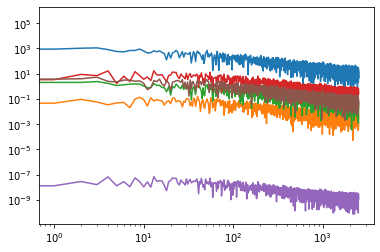

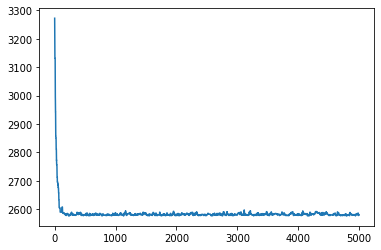

In [188]:
plt.loglog(np.abs(np.fft.rfft(mcmc_out[:,0])))
plt.loglog(np.abs(np.fft.rfft(mcmc_out[:,1])))
plt.loglog(np.abs(np.fft.rfft(mcmc_out[:,2])))
plt.loglog(np.abs(np.fft.rfft(mcmc_out[:,3])))
plt.loglog(np.abs(np.fft.rfft(mcmc_out[:,4])))
plt.loglog(np.abs(np.fft.rfft(mcmc_out[:,5])))
plt.show()
plt.plot(mcmc_out[:,-1])

In [163]:
#print(mcmc_out[0])
#print(planck_chain[0])
#np.savetxt('planck_chain.txt', planck_chain)

In [194]:
H_0, dH_0 = np.mean(mcmc_out[:,0]), np.std(mcmc_out[:,0])
h, dh = H_0/100, dH_0/100
Ombh2, dOmbh2 = np.mean(mcmc_out[:,1]), np.std(mcmc_out[:,1])
Omch2, dOmch2 = np.mean(mcmc_out[:,2]), np.std(mcmc_out[:,2])
Omb = Ombh2/(h**2)
dOmb = Omb*np.sqrt((dOmbh2/Ombh2)**2+(2*dh/h)**2)
Omc = Omch2/(h**2)
dOmc = Omc*np.sqrt((dOmch2/Omch2)**2+(2*dh/h)**2)
dark = 1 - Omb - Omc
ddark = np.sqrt((dOmb)**2+(dOmc)**2)

print('Mean value of Dark Energy is',dark,'with standard deviation of', ddark)

Mean value of Dark Energy is 0.7011740754030835 with standard deviation of 0.011977044535412483


We save the entire chain to planck_chain.txt as requested. Power spectra of the parameter chains were plotted with the use of fourier transform and we observe the curves flattening off on the left hand side, which indicates convergence (or it's more or less getting near convergence).
<br>
Using the equations provided:
<br>
<br>
$h=\frac{H_0}{100}$ and $\Omega_b+\Omega_c+\Omega_\Lambda=1$
<br>
<br>
Mean value for Dark Energy was computed with mean values of each parameter over their chains. Standard deviation of our computed value for Dark Energy was computed using simple error propagation given the equations we used to compute the mean value. Mean value of Dark Energy and its standard deviation was printed in the cell above.

## Question 4

Here we reuse the same mcmc function as in Question 3 except we include sampling from the constrained gaussian distrubtion of tau given in the question. We also set weights according to the tau chain outputted from Q3, comparing the values to the gaussian distribution of tau. (Smaller weights are set for those are higher deviations from the mean tau value constrained) Using the weights we create a covariance matrix from the output of mcmc chain from Q3 and pass that as our re-estimated covariance matrix for our tau constrained mcmc run.

In [224]:
def tau_mcmc(data, start, cov, nstep, scale):
    accepted_steps = 0
    npars = len(start)
    pars = np.zeros((nstep, npars+1))
    pars[0,0:-1] = start
    resid = data-get_spectrum(start)[:len(data)]
    chisq = np.sum((resid/errs)**2) 
    pars[0, -1] = chisq
    pos = start
    for i in range(nstep-1):
        if i%50 == 0:
            print('Step', i)
        new_pos = pos + scale*steps(cov)
        new_pos[3] = np.random.normal(0.0544, 0.0074)
        new_resid = data-get_spectrum(new_pos)[:len(data)]
        new_chisq = np.sum((new_resid/errs)**2)
        if new_chisq < chisq:
            accept = True
            accepted_steps += 1
        else:
            delta_chisq = new_chisq - chisq
            prob = np.exp(-0.5*delta_chisq)
            if np.random.rand()<prob:
                accept = True
                accepted_steps += 1
            else:
                accept = False
        if accept:
            pos = new_pos
            chisq = new_chisq
        pars[i+1, 0:-1] = pos
        pars[i+1, -1] = chisq
    return pars, accepted_steps

In [236]:
weight = np.exp((mcmc_out[:,3]-0.054)**2/(-2*0.0074**2))
cov2 = np.cov(mcmc_out[:,0:-1].T, aweights = weight)

In [232]:
pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
tau_mcmc_out, tau_n_accept = tau_mcmc(spec, pars, cov2, 5000, 0.85)

Step 0
Step 50
Step 100
Step 150
Step 200
Step 250
Step 300
Step 350
Step 400
Step 450
Step 500
Step 550
Step 600
Step 650
Step 700
Step 750
Step 800
Step 850
Step 900
Step 950
Step 1000
Step 1050
Step 1100
Step 1150
Step 1200
Step 1250
Step 1300
Step 1350
Step 1400
Step 1450
Step 1500
Step 1550
Step 1600
Step 1650
Step 1700
Step 1750
Step 1800
Step 1850
Step 1900
Step 1950
Step 2000
Step 2050
Step 2100
Step 2150
Step 2200
Step 2250
Step 2300
Step 2350
Step 2400
Step 2450
Step 2500
Step 2550
Step 2600
Step 2650
Step 2700
Step 2750
Step 2800
Step 2850
Step 2900
Step 2950
Step 3000
Step 3050
Step 3100
Step 3150
Step 3200
Step 3250
Step 3300
Step 3350
Step 3400
Step 3450
Step 3500
Step 3550
Step 3600
Step 3650
Step 3700
Step 3750
Step 3800
Step 3850
Step 3900
Step 3950
Step 4000
Step 4050
Step 4100
Step 4150
Step 4200
Step 4250
Step 4300
Step 4350
Step 4400
Step 4450
Step 4500
Step 4550
Step 4600
Step 4650
Step 4700
Step 4750
Step 4800
Step 4850
Step 4900
Step 4950


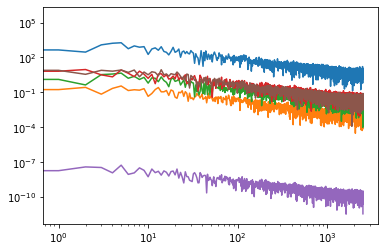

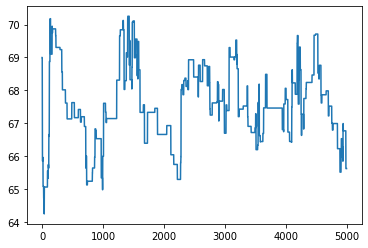

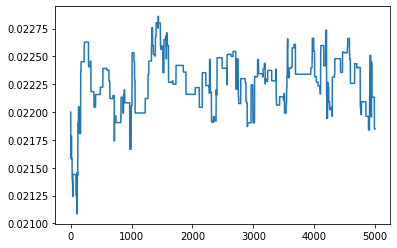

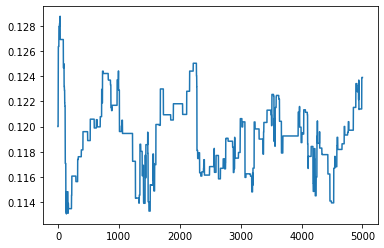

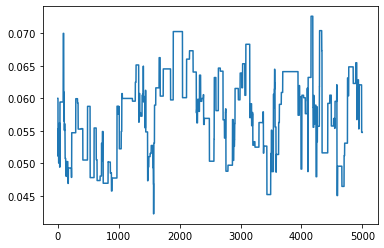

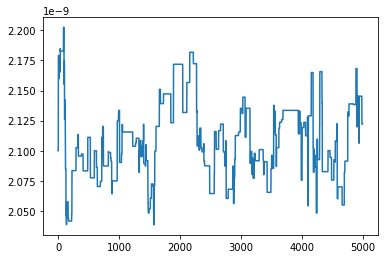

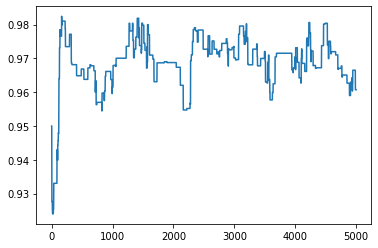

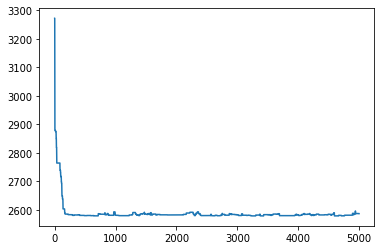

In [244]:
plt.loglog(np.abs(np.fft.rfft(tau_mcmc_out[:,0])))
plt.loglog(np.abs(np.fft.rfft(tau_mcmc_out[:,1])))
plt.loglog(np.abs(np.fft.rfft(tau_mcmc_out[:,2])))
plt.loglog(np.abs(np.fft.rfft(tau_mcmc_out[:,3])))
plt.loglog(np.abs(np.fft.rfft(tau_mcmc_out[:,4])))
plt.loglog(np.abs(np.fft.rfft(tau_mcmc_out[:,5])))
plt.show()
for i in range(len(pars)+1):
    plt.plot(tau_mcmc_out[:,i])
    plt.show()

In [237]:
tau_planck_chain = np.zeros(tau_mcmc_out.shape)
tau_planck_chain[:, [1,2,3,4,5,6,0]] = tau_mcmc_out[:,[0,1,2,3,4,5,6]]
#np.savetxt('planck_chain_tauprior.txt', tau_planck_chain)

In [262]:
for i in range(len(pars)):
    print('mean parameters of chain in Q3', i, 'has mean', np.mean(mcmc_out[:,i]), '+/-', np.std(mcmc_out[:,i]))
    print('importance sampled parameter of chain in Q3',i,' has mean ',np.sum(weight*mcmc_out[:,i])/np.sum(weight))
    print('mean parameters of tau constrained chain', i, 'has mean', np.mean(tau_mcmc_out[:,i]), '+/-', np.std(tau_mcmc_out[:,i]))
    
    

mean parameters of chain in Q3 0 has mean 68.37923025045254 +/- 1.3679488801413782
importance sampled parameter of chain in Q3 0  has mean  67.54187867376851
mean parameters of tau constrained chain 0 has mean 67.56941335114078 +/- 1.1434844067734813
mean parameters of chain in Q3 1 has mean 0.02235371991468489 +/- 0.00023570354313450488
importance sampled parameter of chain in Q3 1  has mean  0.022258052523398936
mean parameters of tau constrained chain 1 has mean 0.02226495136075729 +/- 0.00025218494254121665
mean parameters of chain in Q3 2 has mean 0.11736888929246295 +/- 0.002907489374572684
importance sampled parameter of chain in Q3 2  has mean  0.11917291225100254
mean parameters of tau constrained chain 2 has mean 0.11924965874000436 +/- 0.00279131808891292
mean parameters of chain in Q3 3 has mean 0.09107563016775957 +/- 0.023786510992709068
importance sampled parameter of chain in Q3 3  has mean  0.05701364384697351
mean parameters of tau constrained chain 3 has mean 0.05764

Similarly to the previous questions, the output of the tau constrained chain was saved to planck_chain_tauprior.txt and similarly to Q3, we plot the power spectra of the chain to determine convergence. In the cell above, the mean values for each parameter was printed for the "normal" mcmc chain from Q3 and the tau constrained mcmc chain; the importance sampled parameters of the chains from Q3 were also printed. Here we compare the 3 different values for each parameter and observe that the parameter values of the importance sampled parameters and the tau constrained chain are nearly identical, well within a standard deviation from each other over all 6 parameters. We also notice that for most (all except tau) of the parameters of the "normal" chain from Q3 are close to the values observed with the other 2 methods, often out by 1 standard deviation, except for the tau parameter which is extremely off.